In [342]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class DepthWiseConv2d(nn.Module):
    def __init__(self, in_channels, kernel_size, kernels_per_layer, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*kernels_per_layer, kernel_size=kernel_size, groups=in_channels, bias=bias, padding='same')
    def forward(self, x):
        return self.depthwise(x)

class PointWiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernels_per_layer=1, bias=False):
        super().__init__()
        self.pointwise = nn.Conv2d(in_channels=in_channels*kernels_per_layer, out_channels=out_channels,
                                   kernel_size=(1,1), bias=bias, padding="valid")

    def forward(self, x):
        return self.pointwise(x)

class MaxNormLayer(nn.Linear):
    def __init__(self, in_features, out_features, max_norm=1.0,):
        super(MaxNormLayer, self).__init__(in_features=in_features, out_features=out_features)
        self.max_norm = max_norm

    def forward(self, x):
        if self.max_norm is not None:
            with torch.no_grad():
                self.weight.data = torch.renorm(
                    self.weight.data, p=2, dim=0, maxnorm=self.max_norm
                )
        return super(MaxNormLayer, self).forward(x)

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, kernels_per_layer=1, bias=False):
        super().__init__()
        self.depthwise = DepthWiseConv2d(in_channels=in_channels, kernels_per_layer=kernels_per_layer, kernel_size=kernel_size, bias=bias)
        self.pointwise = PointWiseConv2d(in_channels=in_channels, out_channels=out_channels, kernels_per_layer=kernels_per_layer, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

possíveis melhorias:
1 - trocar batchnorm por layernorm
2 - aplicação de transformer

In [ ]:
class EEGNET(nn.Module):
    def __init__(
        self,
        n_channels,
        n_times,
        n_classes,
        kernel_length=64,
        F1=8,
        D=2,
        F2=16,
        signal_size=32,
        pool1_stride=4,
        pool2_stride=8,
        dropout_rate=0.5,
        norm_rate=0.25,
    ):
        super().__init__()
        #block 1
        self.conv2d = nn.Conv2d(in_channels=n_channels, out_channels=F1, kernel_size=(1, kernel_length), bias=False, padding='same')
        self.batchNorm = nn.BatchNorm2d(num_features=F1, momentum=0.01, eps=0.001, track_running_stats=False)
        self.depthWise = DepthWiseConv2d(in_channels=F1, kernel_size=(n_channels, 1), kernels_per_layer=D, bias=False) #equivalente a convolução depth wise
        #---------------------------------------------------------------------

        #block 2
        self.batchNorm2 = nn.BatchNorm2d(num_features=F1*D, momentum=0.01, eps=0.001, track_running_stats=False)
        self.elu1 = nn.ELU()
        self.avgPool2d = nn.AvgPool2d(kernel_size=(1, pool1_stride), stride=pool1_stride)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.separableConv2d = SeparableConv2d(in_channels=F1*D, kernel_size=(1, 16), out_channels=F2, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(num_features=F2, momentum=0.01, eps=0.001, track_running_stats=False)
        self.elu2 = nn.ELU()
        self.avgPool2d_2 = nn.AvgPool2d(kernel_size=(1, pool2_stride), stride=pool2_stride)
        self.dropout2 = nn.Dropout(dropout_rate)
        #---------------------------------------------------------------------

        #final block
        flatten_output = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(flatten_output, signal_size)
        self.pos_encoder = PositionalEncoding(signal_size, 0.1)
        # self.transformer = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(d_model=flatten_output, dim_feedforward=flatten_output*2, nhead=1, batch_first=True),
        #     num_layers=1
        # )
        self.maxNormLayer = MaxNormLayer(in_features = signal_size, out_features=n_classes, max_norm=norm_rate)
        self.softmax = nn.Softmax(dim=1)

        #buffers
        self.register_buffer('src_mask', EEGNET.generate_src_mask((flatten_output, flatten_output)))

    def forward(self, x, targets):
        out = x.view((x.shape[0], x.shape[1], 1, x.shape[2])) # channel, batch, time (B, C, conv_depth, T)
        out = self.conv2d(out) # (B, F1, F1//2, T)
        out = self.batchNorm(out) # (B, F1, F1//2, T)
        out = self.depthWise(out) # (B, F1*D, F1//2, T)
        out = self.batchNorm2(out) # (B, F1*D, F1//2, T)
        out = self.elu1(out) # (B, F1*D, F1//2, T)
        out = self.avgPool2d(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.dropout1(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.separableConv2d(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.batchNorm3(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.elu2(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.avgPool2d_2(out) # (B, F1*D, F1//(2*pool1_stride), T//F2)
        out = self.dropout2(out) # (B, F1*D, F1//(2*pool1_stride), T//F2)
        out = self.flatten(out) # (B, (F1*D) * (F1//(2*4)) * (T//F2) )
        out = self.linear(out)
        out = out.view(out.shape[1], out.shape[0], 1)
        out = self.pos_encoder(out)
        out = out.view(out.shape[1], out.shape[0], out.shape[2])
        # out = self.transformer(out)
        out = out.mean(2)
        out = self.maxNormLayer(out) # (B, n_classes)
        logits = self.softmax(out) # (B, n_classes)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)


        return logits, loss

    @staticmethod
    def generate_src_mask(src_shape):
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.tril(torch.ones(src_shape), diagonal=0)

    @staticmethod
    def generate_tgt_mask(tgt_shape):
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.ones(tgt_shape)


In [ ]:
model = EEGNET(n_channels=22, n_times=1251, n_classes=4)

model(torch.randn((1, 22, 1251)), torch.zeros((1,)).to(dtype=torch.long))

In [340]:
class TrainerTester:

    @staticmethod
    def train_loop(model, optimizer, X, y, batch_size=32, iterations=1000):
        lossi = []
        for k in range(iterations):
            batch_indexes = torch.randint(0, X.shape[0], (batch_size,))
            X_batch, y_batch = X[batch_indexes], y[batch_indexes] # batch X,Y
            pred, loss = model(X_batch, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #tracking
            lossi.append(loss.log10().item())

            if k % 100 == 0:
                print(f"loss: {loss} iteration: {k}/{iterations}")
                plt.plot(lossi)
                plt.show()

        return lossi

    @staticmethod
    def test_loop(model, Xtest, ytest):
        model.eval()
        X_batch, y_batch = Xtest, ytest

        with torch.no_grad():
            pred, loss = model(X_batch, y_batch)
            correct = (pred.argmax(1) == y_batch).type(torch.float32).sum().item() / y_batch.shape[0]
            kappa = cohen_kappa_score(pred.argmax(1), y_batch)

        print(f"Test loss: {loss:>8f} \n Accuracy: {correct:>8f} \n kappa: {kappa} \n")
        model.train()

    @staticmethod
    def test_and_show(model, Xtest, ytest):
        model.eval()
        X_batch, y_batch = Xtest, ytest
        with torch.no_grad():
            pred, loss = model(X_batch, y_batch)
            print('shapes: ', pred.shape, y_batch.shape)
            accuracy = pred.argmax(1) == y_batch
            model.train()
            return accuracy

In [ ]:
import mne
from moabb.datasets import BNCI2014001


class BciDataHandler:
    def __init__(self):
        self.data = BNCI2014001()
        self.subjects_epochs = {}
        self.subjects_labels = {}
        self.subjects_id = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.sessions_id = ['session_T', 'session_E']
        self.runs_id = ['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5']
        self.events_desc = {'left_hand': 1, 'right_hand': 2, 'both_feet': 3, 'tongue': 4}
        self.tmin, self.tmax, self.t_crop = -.5, 4.5, .5
        self.selected_events = ['left_hand', 'right_hand', 'both_feet', 'tongue']
        self.raw = self.data.get_data(subjects=self.subjects_id)
        self.picks = mne.pick_types(self.raw[1]['session_T']['run_0'].info, eeg=True, stim=False)

    def instantiate_dataset(self):
        for subject_id in self.subjects_id:
            print('subject_id: ', subject_id)
            epochs = []
            for session_id in self.sessions_id:
                print('session_id: ', session_id)
                for run_id in self.runs_id:
                    loop_raw = self.raw[subject_id][session_id][run_id]
                    events = mne.find_events(loop_raw, 'stim')
                    run_epochs = mne.Epochs(
                        loop_raw,
                        events,
                        self.events_desc,
                        picks=self.picks,
                        tmin=self.tmin,
                        tmax=self.tmax,
                        preload=True
                    )[self.selected_events]
                    epochs.append(run_epochs)

            self.subjects_epochs[subject_id] = (mne.concatenate_epochs(epochs)).filter(5, 60)
            self.subjects_labels[subject_id] = [event[2] for event in self.subjects_epochs[subject_id].events]


In [ ]:
data_handler = BciDataHandler()

In [ ]:
data_handler.instantiate_dataset()

In [ ]:
model = EEGNET(n_channels=len(data_handler.picks), n_times=1251, n_classes=len(data_handler.selected_events))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
data_handler.subjects_epochs

In [346]:
seed = 1337
splits = 5

X = torch.tensor(data_handler.subjects_epochs[1].get_data()).to(dtype=torch.float32, device=device)
y = torch.tensor(data_handler.subjects_labels[1]).to(dtype=torch.long, device=device) - 1

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [ ]:
model = model.to(device=device)

In [ ]:
#main-trianing-loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    TrainerTester.train_loop(model, optimizer, X_train, y_train)
    TrainerTester.test_loop(model, X_test, y_test)

Test loss: 1.439422 
 Accuracy: 0.250000 
 kappa: 0.0 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.378404 
 Accuracy: 0.347826 
 kappa: 0.13089480048367608 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.347256 
 Accuracy: 0.382609 
 kappa: 0.17790978654853007 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.446450 
 Accuracy: 0.234783 
 kappa: -0.02170620898536102 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.386813 
 Accuracy: 0.330435 
 kappa: 0.1074488458824715 

shapes:  torch.Size([50, 4]) torch.Size([50])


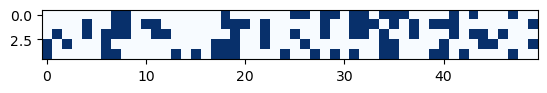

In [345]:
accuracy = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    TrainerTester.test_loop(model, X_test, y_test)
    accuracy.append(TrainerTester.test_and_show(model, X_test[:50], y_test[:50]).tolist())

plt.imshow(accuracy, cmap="Blues")

In [332]:
torch.save(model.state_dict(), 'model_states/model_states.txt')

In [ ]:
model.load_state_dict(torch.load('model_states/model_states.txt'))